# ４章

### word2vecの改良①

In [156]:
#必要なライブラリのインポート
import os 
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

３章で扱ったモデルは小さなコーパス（１文章）のみで考えました。
しかし、通常は非常に大きなコーパスを扱うことになります。

![](picture/pict2.png)

語彙数が100万のCBOWモデルの場合計算量が莫大で

>・重み行列Wの積の計算（in,out)<br>
 ・sofutmaxレイヤでの計算<br>

これらがボトルネックになってしまう。<br>また、入力層のone-hot表現は無駄な要素が多くなることも明らか。

### Embedding レイヤ


入力層では以下の計算がされていた。

![](picture/pict3.png)

ここで行われているのは1つの単語に対応する行列の行を抜き出しているだけ。これを簡略化するために<br>

> 「単語IDに該当する行（ベクトル）」を抜き出すためのレイヤ

を作成しよう。 ここではそのレイヤをEmbeddingと呼ぶことにする。


### Embedding レイヤ の実装

行列から特定の行を抜き出すには、以下のように行う。

In [157]:
W = np.arange(21).reshape(7,3)
print(W) 
print()
print(W[2]) #2行目を取り出す
print()
print(W[5]) #5行目を取り出す

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]

[6 7 8]

[15 16 17]


In [158]:
idx = np.array([1,0,3,0])
W[idx] # 1行目、0行目、3行目、0行目を抽出

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

EmbeddingレイヤのForward()メソッドを実装

In [159]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx # idxを抽出する行のインデックスとして保持
        out = W[idx]
        return out

次は、逆伝播についても考える。
![](picture/pict4.png)

\begin{aligned}
\vec{h} &: (1, 3) \\
\vec{W} &: (L, 3) \text{とすると} \\
\vec{W} &= \begin{pmatrix}
\vec{W_1} \\
\vdots \\
\vec{W_L}
\end{pmatrix} \text{ で, forward で流れた } \vec{h} \text{ について, } \\
\vec{h} &= \vec{W_k} \quad (1 \leq k \leq L) \\
\text{よって, } \quad d\vec{h} &= d\vec{W_k}
\end{aligned}

これを踏まえて実装してみる。


In [160]:
def backward(self, dout):
        dW, = self.grads # dWは重みの勾配
        dW[...] = 0 # dWをゼロで初期化
        dW[self.idx] = dout # 実は悪い例
        return None

### **注意**
自分たちの目的は行列Wの更新なので、いちいちdWのような行列を作る必要はない。

必要な部品は<br>
>・更新したい行番号（idx）<br>
>・その勾配（dout)<br>

これらを保持すれば、重みWの特定の行のみを更新することができる。

しかし、このbackwardには問題点がある。
![](picture/pict5.png)

dhの各行の値をidxで指定された場所へ代入すると、dWの０番目に２つの値が代入されてしまいどちらかの値が上書きされてしまう。この問題は加算して代入することが必要。（理由は板書で説明）

正しい逆伝播の実装は次のようになる。

In [161]:
#逆伝播の修正
def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    np.add.at(dW, self.idx, dout)
    
    return None

以上によって入力層の重み行列の問題が解決された！<br>
### word2vecの改良②

![](picture/pict2.png)

残りの問題は
> 中間層の重み行列の積の計算量<br>
>出力層ソフトマックスの計算量<br>

これらを解決するNegative samplingについて説明していく。
### 多値分類から二値分類へ


結論からいうと、Negative samplingのキーになるアイデアは「**二値分類**」にあります。正確には、「多値分類」を「二値分類」で近似することです。<br>

今までは、NNに対して、<br>
「**コンテキストが『you』と『goodbye』のとき、ターゲットとなる単語はなんですか？**」と質問して学習を行っていました。<br>

これを「yes」「no」で答えられる質問に置き換えます。

例えば<br>
「**コンテキストが『you』と『goodbye』のとき、ターゲットとなる単語は『say』ですか？**」という質問に答えるNNを考えることにすると、ニューロンを一つのみ用意すればよいことになります。


![](picture/pict6.png)

中間層と出力側の重み行列の積は、「say」に対応する列ベクトルだけを取り出し、その抽出したベクトルと中間層のニューロンの内積を取れば良い。

![](picture/pict7.png)

出力側の重みWoutには各単語IDの単語ベクトルが各列に並んで格納されています。ここでは「say」という単語ベクトルを抽出します。

### シグモイド関数と交差エントロピー誤差

「多値分類」から「二値分類」に変えたので、スコアを出力する関数をソフトマックスからシグモイド関数へ変えます。（シグモイド関数はソフトマックスのN＝2のとき）<br>損失関数はそのまま交差エントロピーにします。

##### シグモイド関数

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

##### 交差エントロピー誤差

$$
L = -\left[ t \log(y) + (1 - t) \log(1 - y) \right]
$$

※　tは正解ラベルで、yはシグモイド関数で計算された確率


![](picture/pict8.png)

### 復習　Sigmoid with Loss レイヤ
![](picture/pict9.png)

まず、シグモイド関数の微分は以下の通り
$$
\text{Sigmoid} \quad f(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}
$$

$$
f'(x) = \frac{e^x(e^x + 1) - e^x \cdot e^x}{(e^x + 1)^2} = \frac{e^x}{(e^x + 1)^2}
$$

$$
= \frac{e^x}{e^x + 1} \cdot \frac{1}{e^x + 1} = f(x) \left(1 - f(x)\right)
$$


興味があるのは、xが少し変化したときLはどれくらい変わるのかということ

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{dy}{dx}
$$

$$
= \left( -\frac{t}{y} - \frac{1-t}{1-y} \right) \cdot y(1-y)
$$

$$
= \frac{(1-t)y - (1-y)t}{y(1-y)} \cdot y(1-y) = y - t
$$

In [162]:
#SigmoidWithLossレイヤの実装(復習)
from common.functions import cross_entropy_error

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

これらの議論から二値分類を行うNNは以下のようになります。

![](picture/pict10.png)

入力層と出力層の重み行列の計算は対応するベクトルを抜き出すことで計算量を落とせました。（Embedding）見通しをよくするため、後半部分をよりシンプルにします。

![](picture/pict11.png)

W_outのEmbeddingと中間層の内積をまとめたEmbedding Dotレイヤを作ります。

In [163]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W) # Embeddingレイヤ
        self.params = self.embed.params # パラメータ
        self.grads = self.embed.grads  #勾配
        self.cache = None # 順伝播の入力値を保持

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1) # 3つの要素のリストを(3,1)に変換し、ブロードキャストできるようにする

        dtarget_W = dout * h #(3,1) * (3,7) = (3,7)
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [164]:
#forwardの処理解説
W = np.arange(21).reshape(7,3)
idx = np.array([0,3,1])
h = np.array([[0,1,2],[3,4,5],[6,7,8],]) #中間層のニューロン
embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W * h, axis=1)
#W、idx,target_W,h,target_W * h, outを表にして出力
print("W")
print(W)
print("idx")
print(idx)
print("target_W")
print(target_W)
print("h")
print(h)
print("target_W * h")
print(target_W * h)
print("out")
print(out) # (1,3)の行列

W
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
idx
[0 3 1]
target_W
[[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]]
h
[[0 1 2]
 [3 4 5]
 [6 7 8]]
target_W * h
[[ 0  1  4]
 [27 40 55]
 [18 28 40]]
out
[  5 122  86]


In [165]:
#backwardの処理解説
dout = np.array([1,2,3])
dout = dout.reshape(dout.shape[0], 1)
dtarget_W = dout * h
print("dout")
print(dout)
print("h")
print(h)
print("dout * h")
print(dout * h)
print("dtarget_W")
print(dtarget_W)
dh = dout * target_W
print("dh")
print(dh)

dout
[[1]
 [2]
 [3]]
h
[[0 1 2]
 [3 4 5]
 [6 7 8]]
dout * h
[[ 0  1  2]
 [ 6  8 10]
 [18 21 24]]
dtarget_W
[[ 0  1  2]
 [ 6  8 10]
 [18 21 24]]
dh
[[ 0  1  2]
 [18 20 22]
 [ 9 12 15]]


### Negative sampling

これまで、正例（正しい答え）についてのみ学習を行っていました。<br>

そのため、負例（誤った答え）については、どうなるか定かではありません。<br>

私達は、NNが「いい分類」をしているか、「悪い分類」をしているか教えてあげる必要があります。つまり、「悪い例」を与えることで精度を効率的に上げることを考えます。

![](picture/pict12.png)

では、「悪い例」を教えることにしますが、これは全ての負例について行っていては、計算量を減らすという目的が達成できません。

そこで「悪い例」を少数サンプリングして用いることにします。<br>

この手法を「***Negative Sampling***」といいます。

この手法では、正例と負例についてそれぞれで損失を求め、その総和を最終的な損失として学習をします。

### Negative Samplingのサンプリング手法

サンプリングはどのように行うのでしょうか。完全にランダムにサンプルするよりも、良い方法が知られています。

それはコーパス内の単語の使用頻度に基づいてサンプリングする方法です。

この使用頻度に応じたサンプリングにはnp.random.choice()関数を使います。

In [166]:
#random.choiceの使い方
np.random.choice(10)

1

In [167]:
#wordsの中からランダムに一つ選ぶ
words=['you','say','goodbye','I','hello','.']
np.random.choice(words)

'.'

In [168]:
#5つだけランダムに選ぶ（重複あり）
np.random.choice(words, size=5)

array(['hello', '.', 'say', 'I', 'I'], dtype='<U7')

In [169]:
#5つだけランダムに選ぶ（重複なし）
np.random.choice(words, size=5, replace=False)

array(['.', 'hello', 'I', 'goodbye', 'you'], dtype='<U7')

In [170]:
#確率分布に従ってサンプリング
p=[0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

random.choice()の引数は以下の３つです<br>
size：サンプリングの回数指定<br>
replace：重複の有無（デフォルトはTrue）<br>
p：確率分布を指定

word2vecでは与える確率分布にも一手間加えています。

それは確率分布の小数乗を行うことです。

この操作の意図は出現確率の低い単語の確率を少しだけ上げ、それらの単語を見捨てないようにするためです。

$$
P'(w_i) = \frac{P(w_i)^{0.75}}{\sum_{j=1}^{n} P(w_j)^{0.75}}
$$

In [171]:
p=[0.7, 0.29, 0.01]
new_p=np.power(p, 0.75) #累乗する関数np.power
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


これらの操作をUnigramSamplerクラスとしてまとめます

In [172]:
import sys
sys.path.append('..')
#UnigramSamplerの実装
import collections
from common import config
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        #if not GPU: GPU is not defined というエラーが出るので、コメントアウトしました
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        #else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
         #   negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
         #                                     replace=True, p=self.word_p)

        return negative_sample

In [173]:
#UnigramSamplerのサンプリング
import numpy as np 
import collections

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 0]
 [0 2]
 [2 4]]


### Negative Sampling の実装

In [174]:
#NegativeSamplingLossの実装
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size #負例のサンプリング数
        self.sampler = UnigramSampler(corpus, power, sample_size) #UnigramSamplerの保持
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] #SigmoidWithLossレイヤの保持
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)] #EmbeddingDotレイヤの保持

        #lossレイヤとembed_dotレイヤは負例の数＋正例(sample_size+1)個分用意する

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target): #引数は中間層のニューロンhとターゲットの単語ID
        batch_size = target.shape[0] #バッチサイズ
        negative_sample = self.sampler.get_negative_sample(target) #負例のサンプリング

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32) #正例の正解ラベルは1
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32) #負例の正解ラベルは0
        for i in range(self.sample_size): #負例の数だけループ
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label) #負例の損失を加算
        
        #lossには正例の損失と負例の損失が合算されている

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

### 改良版word2vecの学習

CBOWモデルの実装

この章ではEmbeddingレイヤとNegative sampling loss レイヤを紹介してきました。

これらの改良点を踏まえて前章のSimpleCBOWクラスを改良します。

In [175]:
#改良版CBOWモデルの実装
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding
#from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

では学習を行っていきます。

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 2[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 4[s] | loss 4.13
| epoch 1 |  iter 81 / 9295 | time 5[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 6[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 7[s] | loss 3.79
| epoch 1 |  iter 141 / 9295 | time 9[s] | loss 3.64
| epoch 1 |  iter 161 / 9295 | time 10[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 11[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 12[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 14[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 15[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 16[s] | loss 3.01
| epoch 1 |  iter 281 / 9295 | time 17[s] | loss 2.95
| epoch 1 |  iter 301 / 9295 | time 19[s] | loss 2.91
| epoch 1 |  iter 321 / 9295 | time 20[s] | loss 2.89
| epoch 1 |  iter 341 / 9295 | time 21[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 22[s] 

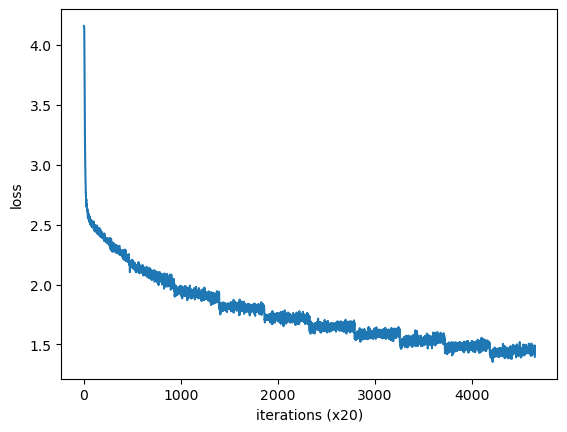

In [176]:
#GPUを使わないと1時間かかるので注意
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
# config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.functions import cross_entropy_error
from common.trainer import Trainer
from common.optimizer import Adam
#from common.cbow import CBOW
#from common.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [177]:
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle

pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.74169921875
 i: 0.7255859375
 your: 0.6328125
 they: 0.60009765625
 anybody: 0.58203125

[query] year
 month: 0.85302734375
 week: 0.77587890625
 spring: 0.76708984375
 summer: 0.7578125
 decade: 0.66845703125

[query] car
 luxury: 0.61083984375
 truck: 0.6064453125
 auto: 0.58740234375
 window: 0.576171875
 cars: 0.55810546875

[query] toyota
 engines: 0.634765625
 weyerhaeuser: 0.630859375
 seita: 0.62890625
 nissan: 0.607421875
 honda: 0.607421875


In [178]:
analogy('king', 'man','queen', word_to_id, id_to_word, word_vecs, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs, top=5)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs, top=5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs, top=5)


[analogy] king:man = queen:?
 woman: 4.84375
 carolinas: 4.8125
 naczelnik: 4.765625
 toxin: 4.75
 yard: 4.578125

[analogy] take:took = go:?
 went: 4.40625
 're: 4.359375
 was: 4.20703125
 a.m: 4.078125
 came: 4.03515625

[analogy] car:cars = child:?
 a.m: 6.234375
 rape: 5.31640625
 children: 5.2265625
 incest: 5.0
 adults: 4.47265625

[analogy] good:better = bad:?
 rather: 6.1953125
 more: 5.80859375
 less: 5.734375
 greater: 4.73046875
 worse: 3.841796875


Done
| epoch 1 |  iter 1 / 8730 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 8730 | time 2[s] | loss 4.16
| epoch 1 |  iter 41 / 8730 | time 5[s] | loss 4.15
| epoch 1 |  iter 61 / 8730 | time 7[s] | loss 4.12
| epoch 1 |  iter 81 / 8730 | time 10[s] | loss 4.04
| epoch 1 |  iter 101 / 8730 | time 13[s] | loss 3.93
| epoch 1 |  iter 121 / 8730 | time 15[s] | loss 3.81
| epoch 1 |  iter 141 / 8730 | time 18[s] | loss 3.69
| epoch 1 |  iter 161 / 8730 | time 20[s] | loss 3.59
| epoch 1 |  iter 181 / 8730 | time 23[s] | loss 3.49
| epoch 1 |  iter 201 / 8730 | time 26[s] | loss 3.41
| epoch 1 |  iter 221 / 8730 | time 28[s] | loss 3.35
| epoch 1 |  iter 241 / 8730 | time 31[s] | loss 3.27
| epoch 1 |  iter 261 / 8730 | time 33[s] | loss 3.23
| epoch 1 |  iter 281 / 8730 | time 36[s] | loss 3.14
| epoch 1 |  iter 301 / 8730 | time 38[s] | loss 3.13
| epoch 1 |  iter 321 / 8730 | time 41[s] | loss 3.07
| epoch 1 |  iter 341 / 8730 | time 43[s] | loss 3.01
| epoch 1 |  iter 361 / 8730 | ti

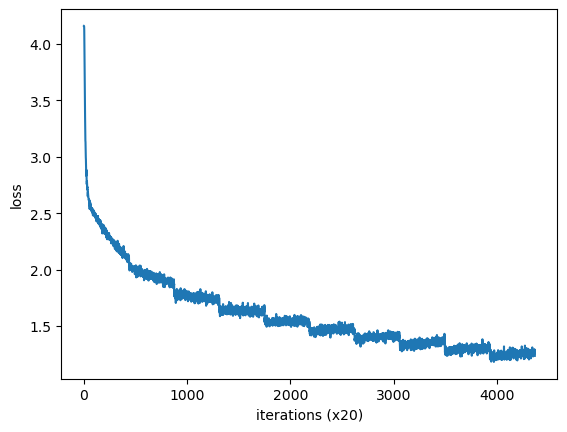

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
# config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import aozorabunko  # ★青空文庫のコーパスを利用するように変更

# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = aozorabunko.load_data('train')  # ★コーパス変更
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task ★クエリを標準入力する形に変更
while True:
    query = input('\n[similar] query? ')
    if not query:
        break
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


# analogy task ★クエリを標準入力する形に変更
print('-'*50)
while True:
    query = input('\n[analogy] query? (3 words) ')
    if not query:
        break
    a, b, c = query.split()
    analogy(a, b, c,  word_to_id, id_to_word, word_vecs)



[query] あなた
 お前: 0.744140625
 妻: 0.67138671875
 奥さん: 0.662109375
 お嬢さん: 0.64794921875
 破談: 0.63330078125

[query] 年
 円: 0.76220703125
 分: 0.74072265625
 世紀: 0.7060546875
 冊: 0.69775390625
 年間: 0.69482421875

[query] 車
 階段: 0.7255859375
 舞台: 0.720703125
 護送: 0.7177734375
 自動車: 0.71630859375
 縄ばしご: 0.712890625

[query] 朝
 天長節: 0.68017578125
 国元: 0.6796875
 郷里: 0.650390625
 新橋: 0.6337890625
 あさって: 0.63232421875

[query] 学校
 大学: 0.77685546875
 下宿: 0.74853515625
 住田: 0.74072265625
 中学校: 0.72265625
 生徒: 0.72119140625

[query] 座敷
 新橋: 0.787109375
 床: 0.77587890625
 南: 0.755859375
 机: 0.74951171875
 端: 0.7373046875

[query] 着物
 纏める: 0.68115234375
 水: 0.6796875
 小犬: 0.67138671875
 球: 0.66943359375
 襯衣: 0.66748046875

[query] 吾輩
 彼等: 0.77734375
 主人: 0.765625
 猫: 0.71875
 余: 0.71044921875
 集: 0.6962890625

[query] 犯人
 子ども: 0.783203125
 あいつ: 0.78173828125
 こんど: 0.76513671875
 わし: 0.76416015625
 魚つり: 0.73828125

[query] 注文
 催促: 0.70654296875
 卒業: 0.6533203125
 承知: 0.65234375
 勉強: 0.65234375
 安心: 0

ValueError: not enough values to unpack (expected 3, got 1)

In [2]:
analogy('男', '王','女', word_to_id, id_to_word, word_vecs, top=5)
analogy('体', '顔', '自動車', word_to_id, id_to_word, word_vecs, top=5)
analogy('行く', '来る', '話す', word_to_id, id_to_word, word_vecs, top=5)
analogy('飯', '食う', '書物', word_to_id, id_to_word, word_vecs, top=5)
analogy('夏', '暑い', '冬', word_to_id, id_to_word, word_vecs, top=5)


[analogy] 男:王 = 女:?
 ず: 4.59375
 ざる: 4.203125
 るる: 4.18359375
 ぬ: 4.13671875
 ない: 3.876953125

[analogy] 体:顔 = 自動車:?
 警官: 6.1875
 少年: 5.97265625
 ふたり: 5.8984375
 係長: 5.87109375
 ドア: 5.76171875

[analogy] 行く:来る = 話す:?
 十一: 5.3359375
 十三: 5.03515625
 三十五: 4.30859375
 言う: 4.19921875
 遺書: 4.16796875

[analogy] 飯:食う = 書物:?
 有し: 4.31640625
 求める: 4.0625
 促: 3.98828125
 人望: 3.927734375
 出来る: 3.8046875

[analogy] 夏:暑い = 冬:?
 たまる: 5.48046875
 くる: 4.90234375
 た: 4.859375
 しまい: 4.62109375
 いる: 4.4140625
